In [50]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import scipy.sparse as sps
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.linalg import pinv
from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit, train_test_split
import itertools
import matplotlib.pyplot as plt
from time import clock
import warnings

warnings.filterwarnings('ignore')

seed = 27

In [35]:
# KMeans
def kMeans(data, k=11, max_iter=500):
    sse = {}
    time = {}
    
    for iter in range(1, k):
        st = clock()
        kmeans = KMeans(n_clusters=iter, max_iter=max_iter, random_state=seed)
        kmeans.fit(data)
        time[iter] = clock() - st
        sse[iter] = kmeans.inertia_
        
        if iter > 1:
            sil_coeff = silhouette_score(data, kmeans.labels_, metric='euclidean')
            print("n_clusters={}, Silhouette Coefficient {}".format(iter, sil_coeff))
            
    plt.subplot(2, 1, 1)
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    
    plt.subplot(2, 1, 2)
    plt.plot(list(time.keys()), list(time.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Run Time")
    
    return plt

In [34]:
def load_csv_data(fileName, targetCol, scaler=preprocessing.MinMaxScaler()):
    data = pd.read_csv(fileName)
#     print (data.columns)
    X = data.loc[:, data.columns != targetCol]
    y = data[targetCol]
    
    X_cols = X.columns
    
    X = pd.DataFrame(scaler.fit_transform(X), columns=X_cols)
    return X, y

n_clusters=2, Silhouette Coefficient 0.24619145662552291
n_clusters=3, Silhouette Coefficient 0.19216977418078277
n_clusters=4, Silhouette Coefficient 0.1708968066998976
n_clusters=5, Silhouette Coefficient 0.1689462362155543
n_clusters=6, Silhouette Coefficient 0.14482351501767735
n_clusters=7, Silhouette Coefficient 0.14346904254288131
n_clusters=8, Silhouette Coefficient 0.13925371489898206
n_clusters=9, Silhouette Coefficient 0.1222534717298127
n_clusters=10, Silhouette Coefficient 0.1266503392333068


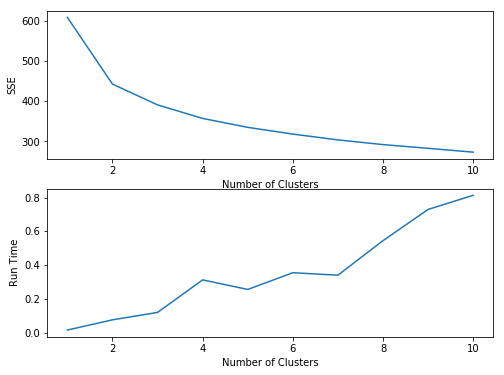

In [71]:
# KMeans for Wine Quality dataset
scaler = preprocessing.MinMaxScaler()
X, y = load_csv_data('./data/winequality-white.csv','GoodQuality', scaler)

plt.figure(1, figsize=(8, 6))
plt = kMeans(X, k=11, max_iter=500)
plt.show()

Accuracy 0.6015


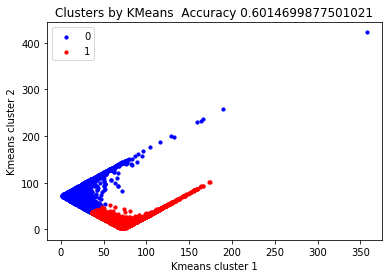

In [124]:
df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

kmeans = KMeans(n_clusters=2, random_state=27)
kmeans.fit(X)
predictions = kmeans.fit_predict(X)

X_train_kmeans = kmeans.fit_transform(X)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_train, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(X_train_kmeans[predictions==0, 0], X_train_kmeans[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(X_train_kmeans[predictions==1, 0], X_train_kmeans[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by KMeans  Accuracy {}".format(acc))
plt.xlabel("Kmeans cluster 1")
plt.ylabel("Kmeans cluster 2")
plt.legend()

In [39]:
# EM - Gaussian Mixture Model
def gMM(data, k=11, max_iter=500):
    bic = {}
    time = {}
    for iter in range(1, k):
        st = clock()
        gmm = GaussianMixture(n_components=iter, random_state=seed, n_init=3, max_iter=max_iter)
        gmm.fit(data)
        
        time[iter] = clock() - st
        bic[iter] = gmm.bic(data)
        
    plt.subplot(2, 1, 1)
    plt.plot(list(bic.keys()), list(bic.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC")
    
    plt.subplot(2, 1, 2)
    plt.plot(list(time.keys()), list(time.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Run Time")
    
    return plt

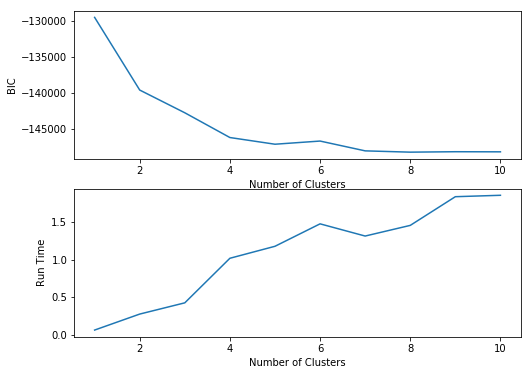

In [40]:
scaler = preprocessing.MinMaxScaler()
# X, y = load_csv_data("Winequality-white.csv", "GoodQuality")

plt.figure(1, figsize=(8, 6))
plt = gMM(X, k=11, max_iter=500)

In [162]:
df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

gaussian = GaussianMixture(n_components=2, random_state=27)
gaussian.fit(X_train)
predictions = gaussian.predict(X_train)
gm_confusion_matrix = confusion_matrix(predictions, y_train)
# plot_confusion_matrix(gm_confusion_matrix)

acc = accuracy_score(y_train, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_train, predictions)
    
print("Accuracy {:.4f}".format(acc))

Accuracy 0.6478


In [150]:
def principal_component_analysis(data, n_components):
    pca = PCA(n_components=n_components, random_state=seed)
    data_pca = pca.fit_transform(data)
    
    var_explained = {}
    rec_error = {}
    
    pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
#     explained_variance = np.var(data_pca, axis=0)
#     explained_variance_ratio = explained_variance / np.sum(explained_variance)
#     pca_cumsum = np.cumsum(explained_variance_ratio)

    for iter in range(n_components):
        var_explained[iter] = pca_cumsum[iter]
        
    plt.figure()
    plt.plot(list(var_explained.keys()), list(var_explained.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Variance Explained")
    
    return plt, var_explained, data_pca

def independent_component_analysis(data, n_components):
    kurto = {}
    
    for iter in range(1, n_components):
        ica = FastICA(n_components=iter, random_state=seed)
        data_ica = ica.fit_transform(data)
        data_ica_df = pd.DataFrame(data_ica)
        data_ica_kurto = data_ica_df.kurtosis(axis=0)
        kurto[iter] = data_ica_kurto.abs().mean()
        
    plt.figure()
    plt.plot(list(kurto.keys()), list(kurto.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Kurtosis")
    
    return plt, kurto, data_ica


def pair_wise_dist_corr(X1, X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(), d2.ravel())[0, 1]

def recon_error(projections, X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
        
    p = pinv(W)
    # unproject data
    reconstructed = ((p@W) @ (X.T)).T
    reconstructed = (np.matmul(np.matmul(p, W), X.T)).T
    errors = np.square(X - reconstructed)
    return np.nanmean(errors)


def random_projections(data, n_components):
    pairw_distcorr = {}
    rec_error = {}
    
    for iter in range (1, n_components):
        rp = SparseRandomProjection(n_components=iter, random_state=seed)
        
        rpcopy = rp
        pairw_distcorr[iter] = pair_wise_dist_corr(rp.fit_transform(data), data)
        
        rpcopy.fit(data)
        rec_error[iter] = recon_error(rpcopy, data)
        
    plt.subplot(2, 1, 1)
    plt.plot(list(pairw_distcorr.keys()), list(pairw_distcorr.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Pairwise Distance Correlation")
    
    plt.subplot(2, 1, 2)
    plt.plot(list(rec_error.keys()), list(rec_error.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error")
    
    return plt, pair_wise_dist_corr, recon_error, rp

def randomForest(X, y, n_estimators, class_weight):
    rfc = RandomForestClassifier(n_estimators=n_estimators, class_weight="balanced",
                                 random_state=seed)
    features = rfc.fit(X, y).feature_importances_
    
    feat_imp = {}
    
    for iter in range(len(X.columns)):
        feat_imp[X.columns[iter]] = features[iter]
        
    return feat_imp
    

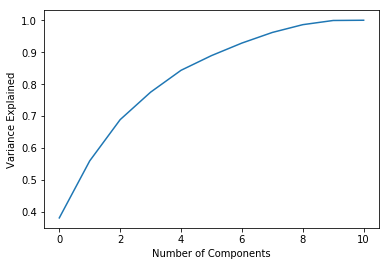

In [95]:
# PCA
X, y = load_csv_data('./data/winequality-white.csv', 'GoodQuality')

n_components = len(X.columns)

plt, var_explained, data_pca = principal_component_analysis(X, n_components)
plt.show()

Text(0, 0.5, 'PCA Reconstruction Error')

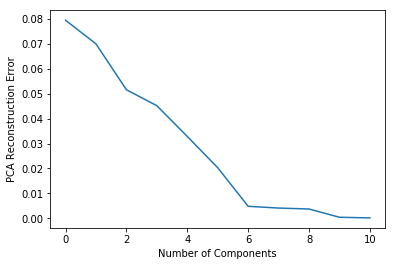

In [155]:
def recon_error(projections, X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
        
    p = pinv(W)
    # unproject data
#     reconstructed = ((p@W) @ (X.T)).T
    reconstructed = (np.matmul(np.matmul(p, W), X.T)).T
    errors = np.square(X - reconstructed)
    return np.nanmean(errors)

scaler = preprocessing.MinMaxScaler()
X, y = load_csv_data("./data/Winequality-white.csv", "GoodQuality")

n_components = len(X.columns)
rec_error = {}

for iter in range(n_components):
    pca = PCA(n_components=iter, random_state=seed)
    data_pca = pca.fit_transform(X)
    rec_error[iter] = recon_error(pca, X)
    
plt.figure()
plt.plot(list(rec_error.keys()), list(rec_error.values()))
plt.xlabel("Number of Components")
plt.ylabel("PCA Reconstruction Error")
    

Accuracy 0.6456


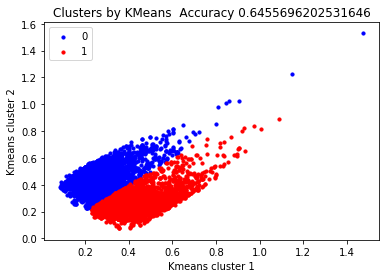

In [125]:
# df = pd.read_csv("./data/winequality-white.csv")

# features = df.columns.values[:-1]
# target = df.columns.values[-1]

# ### One Hot Encode Categorical attributes
# X = df[features]
# y = df[[target]]

# # X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# # X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
# #                                      'pc 8', 'pc 9', 'pc 10'])

# y_nn = pd.get_dummies(y)
# y_nn.drop('GoodQuality_No', 1, inplace=True)
# y_nn.columns = ['GoodQuality']

kmeans = KMeans(n_clusters=2, random_state=27)
kmeans.fit(data_pca)
predictions = kmeans.fit_predict(data_pca)

X_train_kmeans = kmeans.fit_transform(data_pca)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_train, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(X_train_kmeans[predictions==0, 0], X_train_kmeans[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(X_train_kmeans[predictions==1, 0], X_train_kmeans[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by KMeans  Accuracy {}".format(acc))
plt.xlabel("Kmeans cluster 1")
plt.ylabel("Kmeans cluster 2")
plt.legend()

Accuracy 0.6015


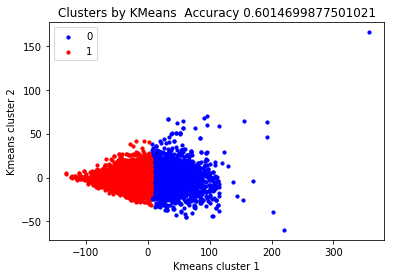

In [172]:
df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

pca = PCA(n_components=6, random_state=27)
data_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=27)
kmeans.fit(data_pca)
predictions = kmeans.fit_predict(data_pca)

X_train_kmeans = kmeans.fit_transform(data_pca)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_nn, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(data_pca[predictions==0, 0], data_pca[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(data_pca[predictions==1, 0], data_pca[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by KMeans  Accuracy {}".format(acc))
plt.xlabel("Kmeans cluster 1")
plt.ylabel("Kmeans cluster 2")
plt.legend()

Accuracy 0.6431


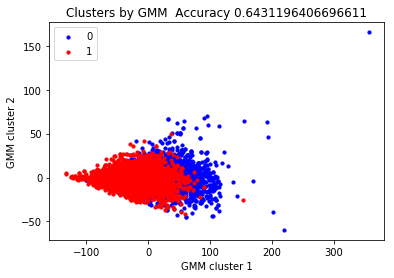

In [173]:
# df = pd.read_csv("./data/winequality-white.csv")

# features = df.columns.values[:-1]
# target = df.columns.values[-1]

# ### One Hot Encode Categorical attributes
# X = df[features]
# y = df[[target]]

# # X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# # X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
# #                                      'pc 8', 'pc 9', 'pc 10'])

# y_nn = pd.get_dummies(y)
# y_nn.drop('GoodQuality_No', 1, inplace=True)
# y_nn.columns = ['GoodQuality']

# pca = PCA(n_components=6, random_state=27)
# data_pca = pca.fit_transform(X)

gaussian = GaussianMixture(n_components=2, random_state=27)
gaussian.fit(data_pca)
predictions = gaussian.predict(data_pca)
gm_confusion_matrix = confusion_matrix(predictions, y_nn)

# kmeans = KMeans(n_clusters=2, random_state=27)
# kmeans.fit(data_pca)
# predictions = kmeans.fit_predict(data_pca)

# X_train_kmeans = kmeans.fit_transform(data_pca)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_nn, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(data_pca[predictions==0, 0], data_pca[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(data_pca[predictions==1, 0], data_pca[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by GMM  Accuracy {}".format(acc))
plt.xlabel("GMM cluster 1")
plt.ylabel("GMM cluster 2")
plt.legend()

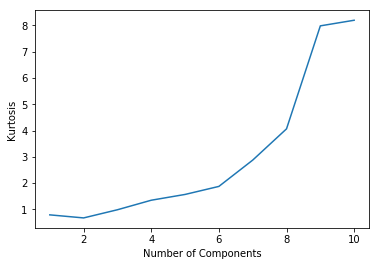

In [136]:
# ICA
scaler = preprocessing.MinMaxScaler()
X, y = load_csv_data("./data/Winequality-white.csv", "GoodQuality")

n_components = len(X.columns)
plt, kurto, data_ica = independent_component_analysis(X, n_components)
plt.show()

Accuracy 0.6196


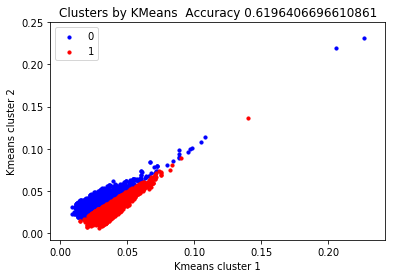

In [176]:
df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

ica = FastICA(n_components=6, random_state=27)
data_ica = ica.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=27)
kmeans.fit(data_ica)
predictions = kmeans.fit_predict(data_ica)

X_train_kmeans = kmeans.fit_transform(data_ica)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_nn, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(X_train_kmeans[predictions==0, 0], X_train_kmeans[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(X_train_kmeans[predictions==1, 0], X_train_kmeans[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by KMeans  Accuracy {}".format(acc))
plt.xlabel("Kmeans cluster 1")
plt.ylabel("Kmeans cluster 2")
plt.legend()

Accuracy 0.6476


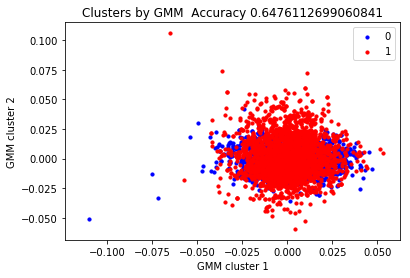

In [180]:
# df = pd.read_csv("./data/winequality-white.csv")

# features = df.columns.values[:-1]
# target = df.columns.values[-1]

# ### One Hot Encode Categorical attributes
# X = df[features]
# y = df[[target]]

# # X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# # X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
# #                                      'pc 8', 'pc 9', 'pc 10'])

# y_nn = pd.get_dummies(y)
# y_nn.drop('GoodQuality_No', 1, inplace=True)
# y_nn.columns = ['GoodQuality']


# ica = FastICA(n_components=6, random_state=27)
# data_ica = ica.fit_transform(X)

gaussian = GaussianMixture(n_components=2, random_state=27)
gaussian.fit(data_ica)
predictions = gaussian.predict(data_ica)
gm_confusion_matrix = confusion_matrix(predictions, y_nn)

# kmeans = KMeans(n_clusters=2, random_state=27)
# kmeans.fit(data_pca)
# predictions = kmeans.fit_predict(data_pca)

# X_train_kmeans = kmeans.fit_transform(data_pca)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_nn, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(data_ica[predictions==0, 0], data_ica[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(data_ica[predictions==1, 0], data_ica[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by GMM  Accuracy {}".format(acc))
plt.xlabel("GMM cluster 1")
plt.ylabel("GMM cluster 2")
plt.legend()

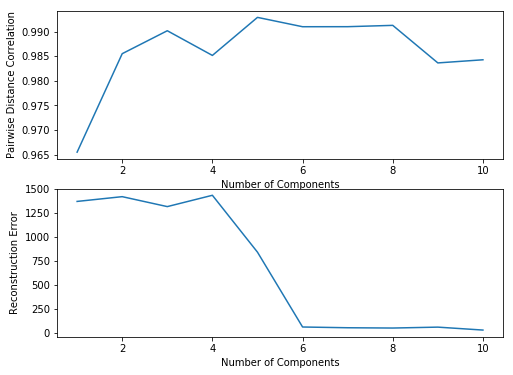

In [151]:
# Random Projection

n_components = len(X.columns)

plt.figure(1, figsize=(8, 6))
plt, pairw_distcorr, rec_error, rp = random_projections(X, n_components)
plt.show()

Accuracy 0.5521


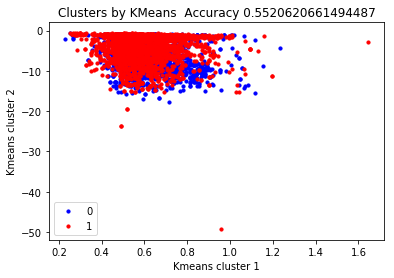

In [181]:
df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

rca = SparseRandomProjection(n_components=6)
data_rca = rca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=27)
kmeans.fit(data_rca)
predictions = kmeans.fit_predict(data_rca)

X_train_kmeans = kmeans.fit_transform(data_rca)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_nn, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(data_rca[predictions==0, 0], data_rca[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(data_rca[predictions==1, 0], data_rca[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by KMeans  Accuracy {}".format(acc))
plt.xlabel("Kmeans cluster 1")
plt.ylabel("Kmeans cluster 2")
plt.legend()

Accuracy 0.5968


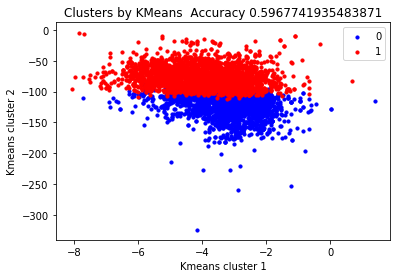

In [182]:
df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

rca = SparseRandomProjection(n_components=6)
data_rca = rca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=27)
kmeans.fit(data_rca)
predictions = kmeans.fit_predict(data_rca)

X_train_kmeans = kmeans.fit_transform(data_rca)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_nn, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(data_rca[predictions==0, 0], data_rca[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(data_rca[predictions==1, 0], data_rca[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by KMeans  Accuracy {}".format(acc))
plt.xlabel("Kmeans cluster 1")
plt.ylabel("Kmeans cluster 2")
plt.legend()

Accuracy 0.5958


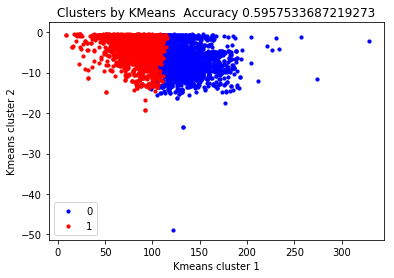

In [183]:
df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

rca = SparseRandomProjection(n_components=6)
data_rca = rca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=27)
kmeans.fit(data_rca)
predictions = kmeans.fit_predict(data_rca)

X_train_kmeans = kmeans.fit_transform(data_rca)
acc = accuracy_score(y_nn, predictions)

if acc < 0.5:
    predictions = np.where(predictions == 0, 1, 0)
    acc = accuracy_score(y_nn, predictions)
    
print("Accuracy {:.4f}".format(acc))

plt.scatter(data_rca[predictions==0, 0], data_rca[predictions==0, 1], s=10, \
            c='blue', label='0')
plt.scatter(data_rca[predictions==1, 0], data_rca[predictions==1, 1], s=10, \
            c='red', label='1')
plt.title("Clusters by KMeans  Accuracy {}".format(acc))
plt.xlabel("Kmeans cluster 1")
plt.ylabel("Kmeans cluster 2")
plt.legend()

In [52]:
# Random Forest selects feature importances
n_estimators = 55

features = randomForest(X, y, n_estimators, "balanced")
features

{'fixed acidity': 0.06506800067489456,
 'volatile acidity': 0.11017289100505887,
 'citric acid': 0.07505517822146159,
 'residual sugar': 0.07916904217540002,
 'chlorides': 0.084362833407832,
 'free sulfur dioxide': 0.09523563661499372,
 'total sulfur dioxide': 0.08449322036581938,
 'density': 0.11126162914086918,
 'pH': 0.07167741767091115,
 'sulphates': 0.061426877344616194,
 'alcohol': 0.16207727337814326}

Text(0, 0.5, 'Gini importance')

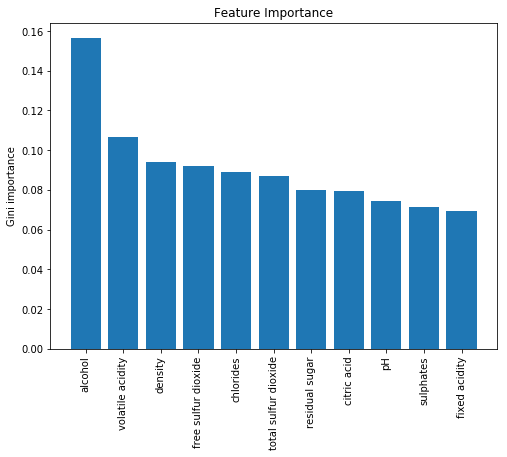

In [147]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X_train = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_train = pd.get_dummies(y)
y_train.drop('GoodQuality_No', 1, inplace=True)
y_train.columns = ['GoodQuality']

model = ExtraTreesClassifier()
model.fit(X_train, y_train.values.ravel())

dict_features = {}
for i in range(len(model.feature_importances_)):
    dict_features.update({X_train.columns[i] : model.feature_importances_[i]})
indices = np.argsort(model.feature_importances_)[::-1]

plt.figure(figsize=(8,6))
plt.bar(range(X_train.shape[1]), model.feature_importances_[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation='vertical')
plt.title("Feature Importance")
plt.ylabel("Gini importance")

n_clusters=2, Silhouette Coefficient 0.2766858681224145
n_clusters=3, Silhouette Coefficient 0.2238492354337508
n_clusters=4, Silhouette Coefficient 0.20159189287052956
n_clusters=5, Silhouette Coefficient 0.2026889503640918
n_clusters=6, Silhouette Coefficient 0.16579496098173552
n_clusters=7, Silhouette Coefficient 0.1696880502111526
n_clusters=8, Silhouette Coefficient 0.16821160706636576
n_clusters=9, Silhouette Coefficient 0.15449988410284088
n_clusters=10, Silhouette Coefficient 0.154843960677634


<module 'matplotlib.pyplot' from 'C:\\Users\\weiguang\\Anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

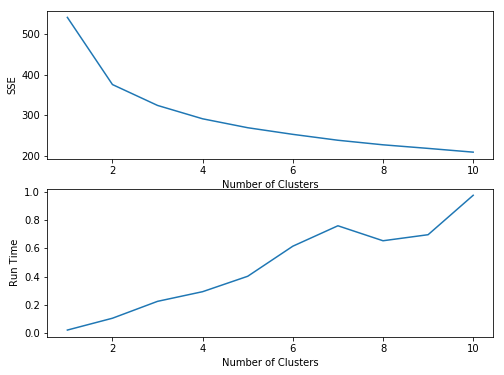

In [57]:
# PCA Dimensionality reduction and Kmeans
scaler = preprocessing.MinMaxScaler()
X, y = load_csv_data("./data/Winequality-white.csv", "GoodQuality", scaler)

X_pca = PCA(n_components=6, random_state=seed).fit_transform(X)
df_pca = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6'])

plt.figure(1, figsize=(8, 6))
kMeans(df_pca, 11)

<module 'matplotlib.pyplot' from 'C:\\Users\\weiguang\\Anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

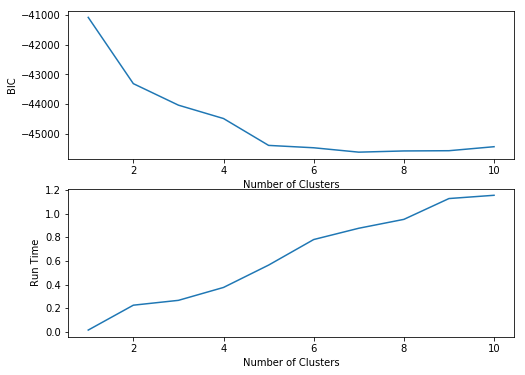

In [59]:
# PCA Dimensionality Reduction and GMM
plt.figure(1, figsize=(8, 6))
gMM(df_pca, 11)

n_clusters=2, Silhouette Coefficient 0.09789001616099886
n_clusters=3, Silhouette Coefficient 0.10918065622650029
n_clusters=4, Silhouette Coefficient 0.11420392143269459
n_clusters=5, Silhouette Coefficient 0.11688881658141659
n_clusters=6, Silhouette Coefficient 0.1239378501254944
n_clusters=7, Silhouette Coefficient 0.12599184135338515
n_clusters=8, Silhouette Coefficient 0.13317522887977765
n_clusters=9, Silhouette Coefficient 0.1303460727808328
n_clusters=10, Silhouette Coefficient 0.12724729417112618


<module 'matplotlib.pyplot' from 'C:\\Users\\weiguang\\Anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

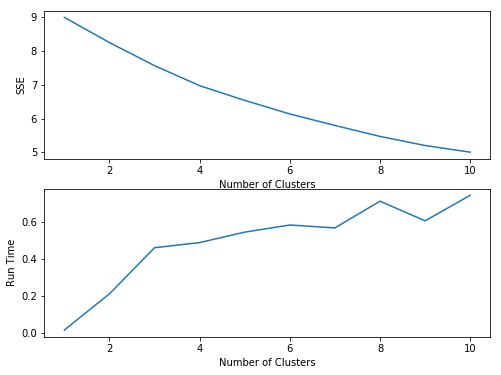

In [61]:
# ICA Dimensionality Reduction and KMeans
scaler = preprocessing.MinMaxScaler()
X, y = load_csv_data("./data/Winequality-white.csv", "GoodQuality")

X_ica = FastICA(n_components=9, random_state=seed).fit_transform(X)
df_ica = pd.DataFrame(data=X_ica, columns=['ic 1', 'ic 2', 'ic 3', 'ic 4', 'ic 5', 'ic 6', 
                                           'ic 7', 'ic 8', 'ic 9'])

plt.figure(1, figsize=(8, 6))
kMeans(df_ica, 11)

<module 'matplotlib.pyplot' from 'C:\\Users\\weiguang\\Anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

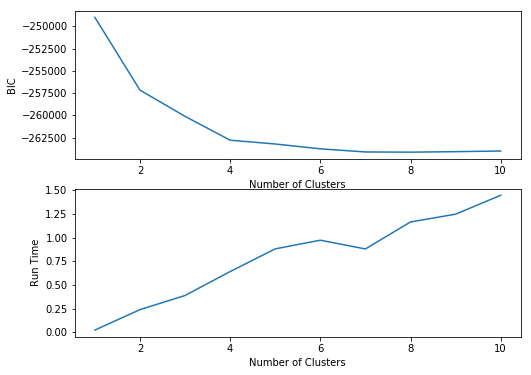

In [63]:
# ICA Dimensionality Reduction and GMM
plt.figure(1, figsize=(8, 6))
gMM(df_ica, 11)

n_clusters=2, Silhouette Coefficient 0.2973351609140971
n_clusters=3, Silhouette Coefficient 0.2994408835506696
n_clusters=4, Silhouette Coefficient 0.27121566362426947
n_clusters=5, Silhouette Coefficient 0.23788267941292351
n_clusters=6, Silhouette Coefficient 0.2361165403068929
n_clusters=7, Silhouette Coefficient 0.22106162863561582
n_clusters=8, Silhouette Coefficient 0.216690399108222
n_clusters=9, Silhouette Coefficient 0.21232635842586212
n_clusters=10, Silhouette Coefficient 0.206029758782758


<module 'matplotlib.pyplot' from 'C:\\Users\\weiguang\\Anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

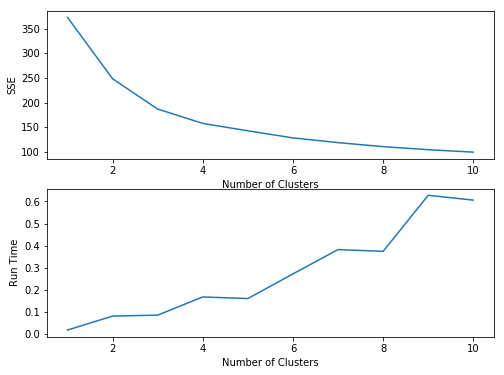

In [65]:
# Random Projection Dimensionality Reduction and KMeans
scaler = preprocessing.MinMaxScaler()
X, y = load_csv_data("./data/Winequality-white.csv", "GoodQuality")

X_rp = SparseRandomProjection(n_components=6, random_state=seed).fit_transform(X)
df_rp = pd.DataFrame(data=X_rp, columns=['rpc 1', 'rpc 2', 'rpc 3', 'rpc 4', 'rpc 5', 'rpc 6'])

plt.figure(1, figsize=(8, 6))
kMeans(df_rp, 11)

<module 'matplotlib.pyplot' from 'C:\\Users\\weiguang\\Anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

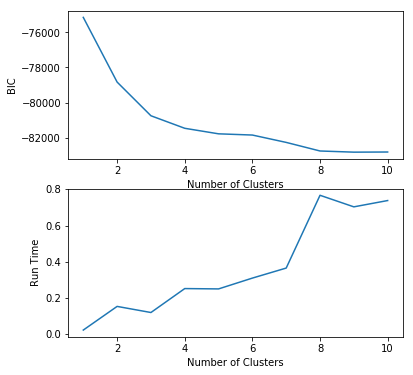

In [70]:
# Random Projection Dimensionality Reduction and GMM
plt.figure(1, figsize=(6, 6))
gMM(df_rp, 11)

In [ ]:
#            nn_test_acc, nn_test_sensitivity, nn_test_specificity
# without pca (0.7806122448979592, 0.5322033898305085, 0.8875912408759125)
# with pca (0.7908163265306123, 0.5728813559322034, 0.8846715328467153)
# with pca + kmeans(0.7857142857142857, 0.5322033898305085, 0.8423357664233576)

In [80]:
df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
                                     'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

X_train, X_test, y_train, y_test = train_test_split(X, y_nn, test_size=0.2, random_state=seed)

X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

X_train.drop('index', 1, inplace=True)
X_test.drop('index', 1, inplace=True)
y_train.drop('index', 1, inplace=True)
y_test.drop('index', 1, inplace=True)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

scaler = preprocessing.MinMaxScaler()
scaler.fit(X=X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, 
                       train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Example Size")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1,
                    color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
            label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
            label='Test score')
    
    plt.legend(loc='best')
    
    return plt

def mlpModel(X_train, y_train, X_test, y_test, cv, seed, neurons=[15], layers=3, 
             activation=['relu'], solver=['adam'], alpha=[0.0001], learning_rate=["constant"],
            learning_rate_init=[0.001], max_iter=[500]):
    hidden_layer_sizes = []
    
    for i in range(1, layers + 1):
        hidden_layer_sizes += [x for x in itertools.product(neurons, repeat=i)]
        
    # hyper-parameter tuning
    parameters = {'hidden_layer_sizes': hidden_layer_sizes, 'activation': activation, 
                  'solver': solver, 'alpha': alpha, 'learning_rate': learning_rate, 
                  'learning_rate_init': learning_rate_init, 'max_iter': max_iter}
    nnModel = GridSearchCV(MLPClassifier(random_state=seed), parameters, cv=cv, n_jobs=4)
    nnModel.fit(X_train, y_train)
    
    cv_acc = nnModel.best_score_
    cv_bestparams = nnModel.best_params_
    
    y_pred = nnModel.predict(X_test)
    
    # Calculate accuracy matrics
    test_acc = accuracy_score(y_test, y_pred)
    cmatrix = confusion_matrix(y_test, y_pred)
    test_sensitivity = cmatrix[0,0] / (cmatrix[0,0] + cmatrix[0,1])
    test_specificity = cmatrix[1,1] / (cmatrix[1,0] + cmatrix[1,1])
    
    return [X_train.shape[0], X_test.shape[0], cv_acc, cv_bestparams, test_acc, test_sensitivity,
           test_specificity, cmatrix]

In [81]:
lr = ["constant"]
neurons = range(20, 40, 10)
layers = 3
activation = ['logistic', 'relu']
solver = ['adam']
alpha = [0.0001]
# alpha = [i/100000 for i in range(0, 1050, 50)]
max_iter = [1000]
# max_iter = [i for i in range(100, 1100, 100)]

nn_train_size, nn_test_size, nn_cv_acc, nn_best_params, nn_test_acc, nn_test_sensitivity, \
nn_test_specificity, nn_cmatrix = mlpModel(X_train, y_train, X_test, y_test, cv=4, seed=seed, \
                        learning_rate=lr, neurons=neurons, layers=layers, activation=activation, \
                        solver=solver, alpha=alpha, max_iter=max_iter)

<module 'matplotlib.pyplot' from 'C:\\Users\\weiguang\\Anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

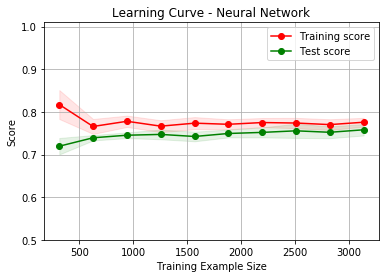

In [84]:
nnmodel = MLPClassifier(random_state=seed, activation=nn_best_params['activation'], \
    alpha=nn_best_params['alpha'], hidden_layer_sizes=nn_best_params['hidden_layer_sizes'],
    learning_rate=nn_best_params['learning_rate'], learning_rate_init=nn_best_params['learning_rate_init'],
    max_iter=nn_best_params['max_iter'])

nnmodel.fit(X_train, y_train)

plot_learning_curve(nnmodel, "Learning Curve - Neural Network", X_train, y_train, ylim=(0.5, 1.01),
                   cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0), n_jobs=4,
                    train_sizes=np.linspace(.1, 1.0, 10))

In [85]:
nn_test_acc, nn_test_sensitivity, nn_test_specificity

(0.7908163265306123, 0.5728813559322034, 0.8846715328467153)

In [87]:
# without PCA

df = pd.read_csv("./data/winequality-white.csv")

features = df.columns.values[:-1]
target = df.columns.values[-1]

### One Hot Encode Categorical attributes
X = df[features]
y = df[[target]]

# X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
# X = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6', 'pc 7',
#                                      'pc 8', 'pc 9', 'pc 10'])

y_nn = pd.get_dummies(y)
y_nn.drop('GoodQuality_No', 1, inplace=True)
y_nn.columns = ['GoodQuality']

X_train, X_test, y_train, y_test = train_test_split(X, y_nn, test_size=0.2, random_state=seed)

X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

X_train.drop('index', 1, inplace=True)
X_test.drop('index', 1, inplace=True)
y_train.drop('index', 1, inplace=True)
y_test.drop('index', 1, inplace=True)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

scaler = preprocessing.MinMaxScaler()
scaler.fit(X=X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lr = ["constant"]
neurons = range(20, 40, 10)
layers = 3
activation = ['logistic', 'relu']
solver = ['adam']
alpha = [0.0001]
# alpha = [i/100000 for i in range(0, 1050, 50)]
max_iter = [1000]
# max_iter = [i for i in range(100, 1100, 100)]

nn_train_size, nn_test_size, nn_cv_acc, nn_best_params, nn_test_acc, nn_test_sensitivity, \
nn_test_specificity, nn_cmatrix = mlpModel(X_train, y_train, X_test, y_test, cv=4, seed=seed, \
                        learning_rate=lr, neurons=neurons, layers=layers, activation=activation, \
                        solver=solver, alpha=alpha, max_iter=max_iter)

nn_test_acc, nn_test_sensitivity, nn_test_specificity

Index(['GoodQuality_Yes'], dtype='object')


(0.7806122448979592, 0.5322033898305085, 0.8875912408759125)

In [159]:
# PCA Dimensionality Reduciton + Kmeans + Neural Network

scaler = preprocessing.MinMaxScaler()
X, y = load_csv_data("./data/winequality-white.csv", "GoodQuality")

X_pca = PCA(n_components=10, random_state=seed).fit_transform(X)
df_pca = pd.DataFrame(data=X_pca, columns=['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5', 'pc 6',
                                          'pc 7', 'pc 8', 'pc 9', 'pc 10'])

kmeans_pca = KMeans(n_clusters=2, max_iter=500, random_state=seed).fit(df_pca)
df_pca['cluster'] = kmeans_pca.labels_

y_nn = pd.get_dummies(y)
# print(y_nn.columns)
y_nn.drop('No', 1, inplace=True)
y_nn.columns=['GoodQuality']

X_train, X_test, y_train, y_test = train_test_split(df_pca, y_nn, test_size=0.2, random_state=seed)

X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

X_train.drop('index', 1, inplace=True)
X_test.drop('index', 1, inplace=True)
y_train.drop('index', 1, inplace=True)
y_test.drop('index', 1, inplace=True)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

nn_train_size, nn_test_size, nn_cv_acc, nn_best_params, nn_test_acc, nn_test_senstivity, \
nn_test_specificity, nn_cmatrix = mlpModel(X_train, y_train, X_test, y_test, cv=4, seed=seed,\
                                          learning_rate=lr, neurons=neurons, layers=layers, \
                                          activation=activation, solver=solver, alpha=alpha,
                                          max_iter=max_iter)

<module 'matplotlib.pyplot' from 'C:\\Users\\weiguang\\Anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

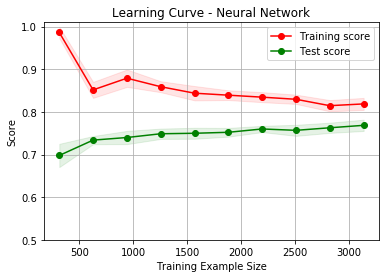

In [160]:
nnmodel = MLPClassifier(random_state=seed, activation=nn_best_params['activation'], \
    alpha=nn_best_params['alpha'], hidden_layer_sizes=nn_best_params['hidden_layer_sizes'],
    learning_rate=nn_best_params['learning_rate'], learning_rate_init=nn_best_params['learning_rate_init'],
    max_iter=nn_best_params['max_iter'])

nnmodel.fit(X_train, y_train)

plot_learning_curve(nnmodel, "Learning Curve - Neural Network", X_train, y_train, ylim=(0.5, 1.01),
                   cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0), n_jobs=4,
                    train_sizes=np.linspace(.1, 1.0, 10))

In [94]:
nn_test_acc, nn_test_sensitivity, nn_test_specificity

(0.7857142857142857, 0.5322033898305085, 0.8423357664233576)